# using acs_regional_stats to calculate an area-averaged time series
This notebook shows an example of using acs_regional_stats to calculate an area-averaged time series.

1. calculate regional averages.
2. then visualise time series for a selected region




In [1]:
# navigate to your directory with "plotting maps" 

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions
import xarray as xr
import geopandas as gpd
import regionmask
import cartopy.crs as ccrs
from glob import glob
import numpy as np
import seaborn as sns

In [4]:
# %load_ext memory_profiler


In [5]:
# mask
# select masks that define the regions you want to work with
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})

# mask where precipitaiton data is unreliable
directory = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i"
agcd = xr.open_dataset(f"{directory}/mask-fraction_agcd_v1-0-2_precip_weight_1960_2022.nc").fraction

In [6]:
# choose a list of files to open
# this list of files will be combined to form a dataset with model, time, lat, and lon dimensions
# we will calculate regional averages and then calculate timeseries for a selected region for each model


var = "TXx"
gwl="GWL12"
path = f"/g/data/ia39/ncra/heat/data/{var}/raw/individual_models/GWL-timeseries"

filelist = glob(f"{path}/{var}_*_{gwl}.nc")
filelist

['/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CNRM-ESM2-1_ssp370_r1i1p1f2_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_BARPA-R_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_BARPA-R_v1-r1

In [7]:
# open the list of files into one xarray dataset
def _preprocess(ds, var, gwl):
    # mask where precipitation data is unreliable
    return ds.convert_calendar("standard")

ds = xr.open_mfdataset(filelist, 
                       preprocess= lambda ds: _preprocess(ds, var, gwl),
                       use_cftime=True,
                       combine="nested",
                       concat_dim="model",
                       combine_attrs= "drop_conflicts").load()
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (model: 13, time: 45, lat: 691, lon: 886)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * time     (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
Dimensions without coordinates: model
Data variables:
    TXx      (model, time, lat, lon) float32 1GB nan nan nan ... 31.64 31.64
Attributes:
    pathway:                 ssp370
    GWL:                     GWL 1.2 degC
    bias_correction_method:  raw
    contact:                 Mitchell Black (mitchell.black@bom.gov.au)
    code:                    https://github.com/AusClimateService/hazards-heat

In [8]:
%%time
# use acs_regiona_stats to calculate the regional mean for each model and month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
da_summary

CPU times: user 9.3 s, sys: 2.78 s, total: 12.1 s
Wall time: 12.2 s


<xarray.Dataset> Size: 49kB
Dimensions:   (time: 45, region: 10, model: 13)
Coordinates:
  * time      (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    TXx_mean  (model, time, region) float64 47kB nan nan nan ... 45.11 44.03
Attributes:
    long_name:      annual maximum daily maximum temperature
    standard_name:  air_temperature
    units:          degC
    regrid_method:  bilinear
    cell_methods:   time: maximum (interval: 1Y)

In [9]:
%%time
# use acs_regiona_stats to calculate the regional mean for each model and month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"], chunks=4,)
da_summary

CPU times: user 5.01 s, sys: 2.3 s, total: 7.31 s
Wall time: 7.31 s


<xarray.Dataset> Size: 49kB
Dimensions:   (model: 13, time: 45, region: 10)
Coordinates:
  * time      (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    TXx_mean  (model, time, region) float64 47kB nan nan nan ... 45.11 44.03
Attributes:
    long_name:      annual maximum daily maximum temperature
    standard_name:  air_temperature
    units:          degC
    regrid_method:  bilinear
    cell_methods:   time: maximum (interval: 1Y)

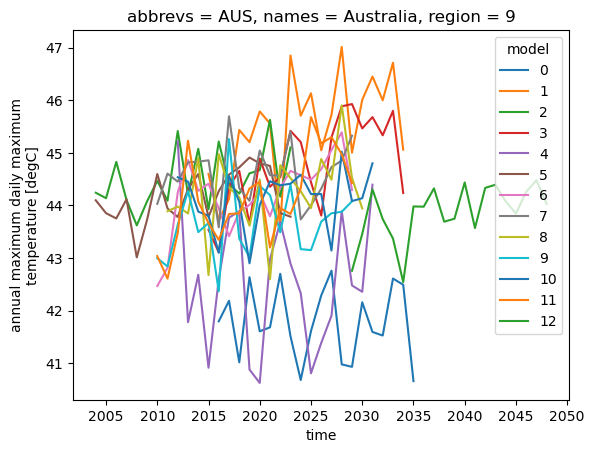

In [10]:
# select the region you like and plot the regional average for each month of each model
da_summary[f"{var}_mean"].sel(region=9).plot.line(x="time");

<Axes: xlabel='time', ylabel='TXx_mean'>

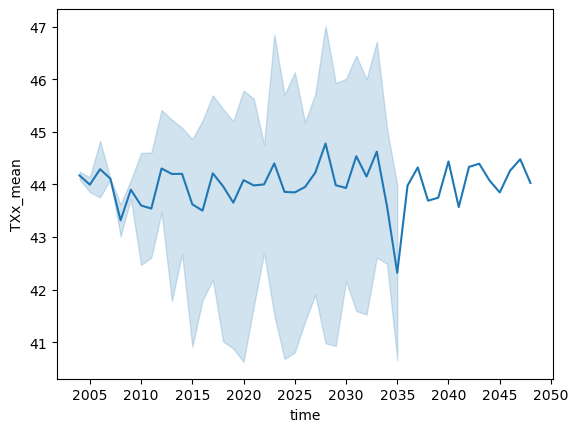

In [11]:
# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="time", y= f"{var}_mean",  errorbar=("pi", 100) )

In [12]:
# for large amounts of daily data and a custom region (new mask needed)

In [13]:
# this is a very large dataset which cannot be computed without "chunks". The kernel will die.
file = "/g/data/rr3/downscaling/CMIP5_Downscaled_CCAM_QLD10/RCP45/daily/MaximumTemperature/tmaxscr.daily.ccam10_ACCESS1-0Q_rcp45.nc"
ds = xr.open_dataset(file).convert_calendar("standard")
ds

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 43800, lat: 226, lon: 261)
Coordinates:
  * lat      (lat) float64 2kB -32.0 -31.9 -31.8 -31.7 ... -9.8 -9.7 -9.6 -9.5
  * lon      (lon) float64 2kB 132.0 132.1 132.2 132.3 ... 157.8 157.9 158.0
  * time     (time) datetime64[ns] 350kB 1980-01-01T15:00:00 ... 2099-12-31T1...
Data variables:
    tmaxscr  (time, lat, lon) float32 10GB 296.5 296.5 297.7 ... 303.9 303.8
Attributes: (12/31)
    Conventions:              CF-1.7
    title:                    Queensland future climate projections derived f...
    institution:              Queensland Department of Environment and Science
    references:               The Long Paddock
    comment:                  Data produced for the LongPaddock Queensland Fu...
    contact:                  longpaddock@qld.gov.au
    ...                       ...
    rlat0:                    -20.0
    schmidt:                  0.19
    date_created:             2020-01-20T18:14:26+10:00
    date_produced:            2016-04-15
    date_metadata_modified:   2020-01-20
    history:                  2016-04-15: Interpolated from the original cubi...

In [14]:
%%time
# # define the mask for the diffrerent grid
# # can just use internal mask calculation in acs_regional_stats
regions= get_regions(["ncra_regions", "australia"])

# mask = regions.mask_3D_frac_approx(ds)

CPU times: user 13.2 s, sys: 470 ms, total: 13.6 s
Wall time: 14 s


In [15]:
%%time

var="tmaxscr"

da_summary = acs_regional_stats(ds=ds,
                                var=var,
                                regions = regions,
                                mask = "fractional", 
                                dims = ("lat", "lon",), 
                                how = ["mean"],
                                chunks=365,
                                outfile="out.csv")
da_summary

!warning very slow! Calculating fractional mask every time is very slow.         
Please consider calculating `mask = regions.mask_3D_frac_approx(ds)` before function.
CPU times: user 26.6 s, sys: 14.1 s, total: 40.7 s
Wall time: 40.8 s


<xarray.Dataset> Size: 2MB
Dimensions:       (time: 43800, region: 6)
Coordinates:
  * time          (time) datetime64[ns] 350kB 1980-01-01T15:00:00 ... 2099-12...
  * region        (region) int64 48B 2 4 6 7 8 9
    abbrevs       (region) <U8 192B 'NSW' 'SA' 'NT' 'QLDNorth' 'QLDSouth' 'AUS'
    names         (region) <U48 1kB 'New South Wales and Australian Capital T...
Data variables:
    tmaxscr_mean  (time, region) float64 2MB 307.2 313.2 310.1 ... 315.9 314.2
Attributes:
    long_name:     Maximum screen temperature
    units:         K
    cell_methods:  time: mean

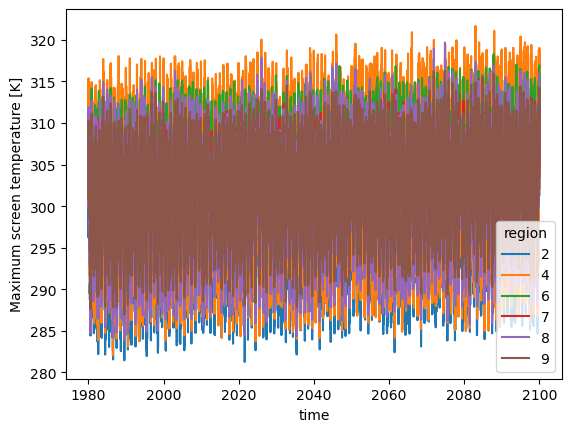

In [16]:
da_summary[f"{var}_mean"].plot.line(x="time")

<Axes: xlabel='time', ylabel='tmaxscr_mean'>

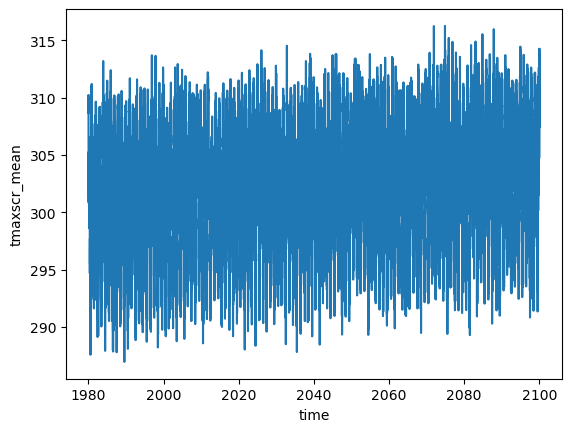

In [19]:
# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="time", y= f"{var}_mean",  errorbar=("pi", 100) )